In [631]:
import pandas as pd
import geopandas as gpd
import numpy as np
import os
import requests
from matplotlib import pyplot as plt
import warnings 
warnings.filterwarnings('ignore')
import statsmodels.formula.api as smf
import re
import math


In [569]:
def load_data(file_path, url_path):
    if os.path.exists(file_path):
        df = pd.read_csv(file_path)
    else:
        #process request in batches...
        d,i,offset_size = [],0,100000
        k = offset_size
        while k == offset_size:
            if i > 10:
                break
            r=requests.get(
                url = url_path, 
                params={
                    '$limit':offset_size, 
                    '$offset':offset_size*i
                }
            )
            as_df = pd.DataFrame(r.json())
            k = len(as_df)
            i += 1
            d.append(as_df)
    
        df = pd.concat(d)
        df.to_csv(file_path)
        df.head(10)
    return df

In [571]:
tree_census_df =load_data('tree_census/flatfiles/tree_census_15.csv', 'https://data.cityofnewyork.us/resource/5rq2-4hqu.json')

In [573]:
air_quality_df = load_data('data/Air_Quality_20241206.csv', 'https://data.cityofnewyork.us/resource/c3uy-2p5r.json')

In [575]:
green_streets_df = load_data('data/Greenstreets.csv', 'https://data.cityofnewyork.us/resource/mk9u-qu7i.json')

In [737]:
property_valuation_df = load_data('data/Property_Valuation_and_Assessment_Data_20241125.csv', 'https://data.cityofnewyork.us/resource/yjxr-fw8i.json')

# Tree Census Data Sanitation 

In [579]:
cols = [
    'tree_id','block_id','the_geom','zipcode','cb_num','borocode','nta_name',
    'health','status','tree_dbh','spc_common','spc_latin','problems','sidewalk',
]

tree_census_tr = tree_census_df[cols]

#only consider alive trees
tree_census_tr = tree_census_tr.loc[tree_census_df['status']=='Alive']

#drop trees without a health label 
tree_census_tr = tree_census_tr.loc[~tree_census_tr['health'].isna()]
tree_census_tr['tree_dbh'] = tree_census_tr['tree_dbh'].astype(int)

tree_census_tr.head()

,tree_id,block_id,the_geom,zipcode,cb_num,borocode,nta_name,health,status,tree_dbh,spc_common,spc_latin,problems,sidewalk
0,180683,348711,"{'type': 'Point', 'coordinates': [-73.84421521...",11375,406,4,Forest Hills,Fair,Alive,3,red maple,Acer rubrum,NaN,NoDamage
1,200540,315986,"{'type': 'Point', 'coordinates': [-73.81867945...",11357,407,4,Whitestone,Fair,Alive,21,pin oak,Quercus palustris,Stones,Damage
2,204026,218365,"{'type': 'Point', 'coordinates': [-73.93660770...",11211,301,3,East Williamsburg,Good,Alive,3,honeylocust,Gleditsia triacanthos var. inermis,NaN,Damage
3,204337,217969,"{'type': 'Point', 'coordinates': [-73.93445615...",11211,301,3,East Williamsburg,Good,Alive,10,honeylocust,Gleditsia triacanthos var. inermis,Stones,Damage
4,189565,223043,"{'type': 'Point', 'coordinates': [-73.97597938...",11215,306,3,Park Slope-Gowanus,Good,Alive,21,American linden,Tilia americana,Stones,Damage


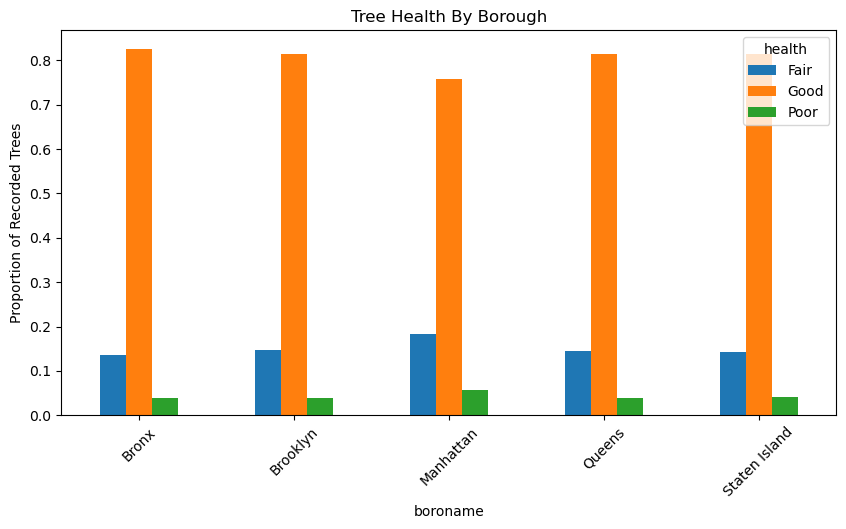

In [581]:
by_boro = tree_census_df.groupby(['boroname','health'])[['tree_id']].count().reset_index()
boro_ttls = by_boro.groupby(['boroname'])['tree_id'].transform(sum)
by_boro['Tree Health Proportion'] = by_boro['tree_id'] / boro_ttls
by_boro.pivot(
    index='boroname',
    columns='health', 
    values='Tree Health Proportion'
).plot(kind='bar', figsize=(10,5))
plt.ylabel('Proportion of Recorded Trees')
plt.title('Tree Health By Borough')
plt.xticks(rotation=45)
plt.show()

In [583]:
#make analysis at zipcode level...
cb_grp = tree_census_tr.groupby(['cb_num']).agg(
    tree_count=('tree_id', len), 
    tree_size=('tree_dbh', np.sum)
)

#avg tree size (diameter)
cb_grp['tree_size'] = cb_grp['tree_size']/cb_grp['tree_count']

#count trees per zip/health category (good, fair, bad), then pivot on the health cats
cb_grp_health_status = tree_census_tr.groupby(['cb_num','health'])[['tree_id']].count().reset_index()
cb_grp_health_status_piv = cb_grp_health_status.pivot(
    index='cb_num',
    columns='health', 
    values='tree_id'
)

#concat cb features
cb_grp_health_status_piv = cb_grp_health_status_piv.div(cb_grp['tree_count'], axis=0)
tree_cb_features = pd.concat((cb_grp_health_status_piv,cb_grp),axis=1)

tree_cb_features['Good'] = tree_cb_features['Good'].fillna(0.0)
tree_cb_features = tree_cb_features.rename(
    columns={
        'Good':'Tree Quality'
    }
)

tree_cb_features = tree_cb_features.reset_index()
tree_cb_features['cb_num'] = tree_cb_features['cb_num'].astype(str)
tree_cb_features = tree_cb_features[['cb_num', 'Tree Quality', 'tree_count']]
tree_cb_features.head()

,cb_num,Tree Quality,tree_count
0,101,0.764040,2297
1,102,0.730602,4833
2,103,0.764069,4709
3,104,0.824395,4419
4,105,0.673560,2031


In [585]:
cb_geometries = gpd.read_file("tree_census/flatfiles/Community Districts.geojson")
geo_cols = ['boro_cd','shape_area','geometry']
cb_geometries = cb_geometries[geo_cols].rename(
    columns={
        'boro_cd':'cb_num'
    }
)
tree_census_geoms = tree_cb_features.merge(
    cb_geometries, 
    how='inner', 
    on='cb_num'
)

#compute acreage over the cb district, calculate trees per acre
tree_census_geoms['cb_acreage'] = tree_census_geoms['shape_area'].astype(np.float64)/43560
tree_census_geoms['Tree Density (per Acre)'] = tree_census_geoms['tree_count']/tree_census_geoms['cb_acreage']

tree_census_geoms = tree_census_geoms[['cb_num','Tree Quality','Tree Density (per Acre)','geometry']]
tree_census_geoms['cb_num'] = tree_census_geoms['cb_num'].astype(np.int64)
tree_census_geoms=tree_census_geoms.set_index('cb_num')
tree_census_geoms.head()


,Tree Quality,Tree Density (per Acre),geometry
cb_num,,,
101,0.764040,2.399876,"MULTIPOLYGON (((-74.04388 40.69019, -74.04351 ..."
102,0.730602,5.580675,"MULTIPOLYGON (((-74.00915 40.74250, -74.00902 ..."
103,0.764069,4.375522,"MULTIPOLYGON (((-73.98878 40.73397, -73.98757 ..."
104,0.824395,3.903700,"MULTIPOLYGON (((-73.99394 40.77318, -73.99370 ..."
105,0.673560,2.020331,"MULTIPOLYGON (((-73.97301 40.76428, -73.97141 ..."


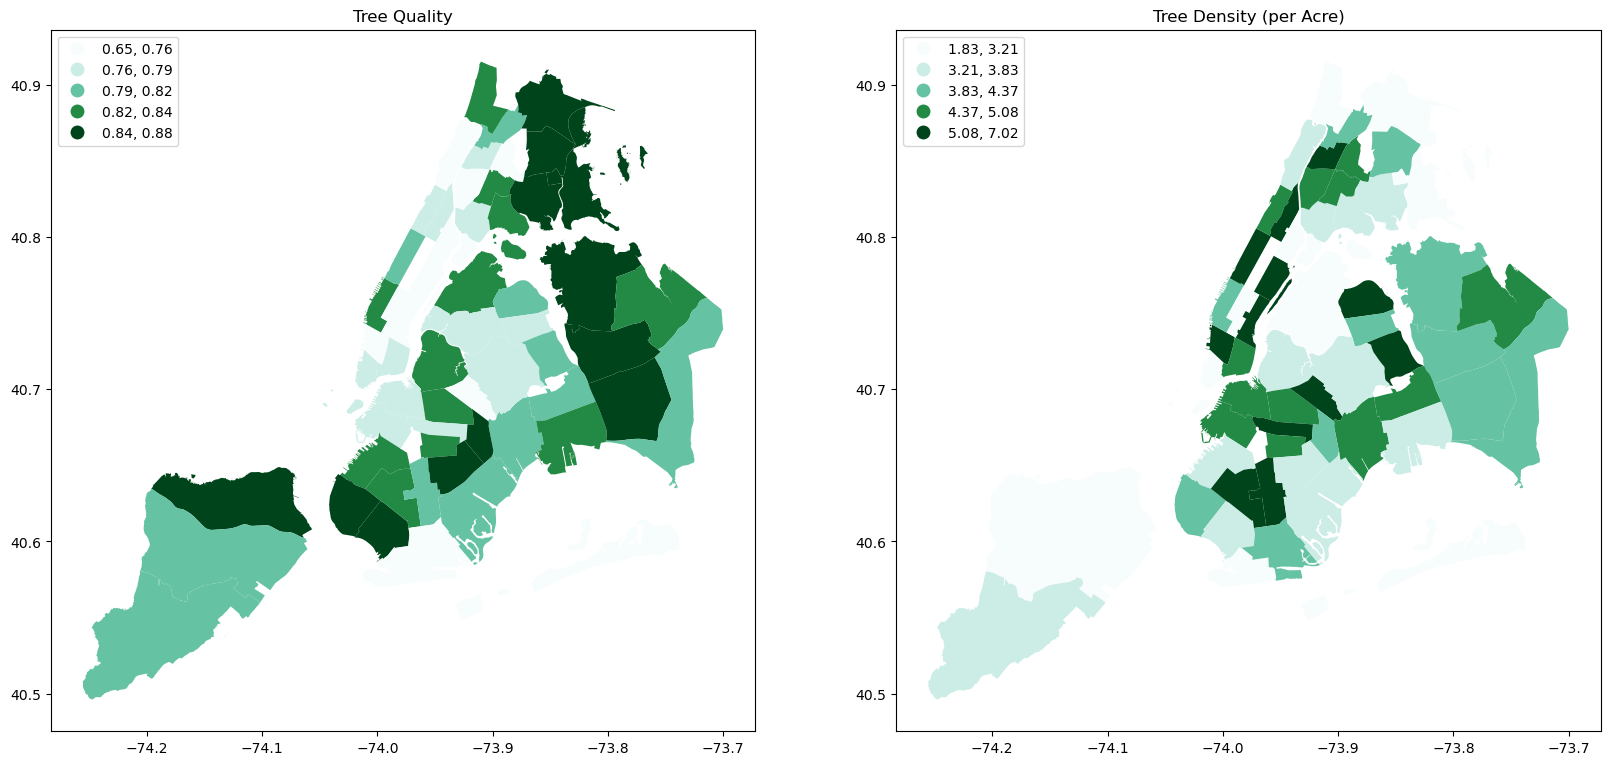

In [587]:
fig, ax = plt.subplots(1,2,figsize=(20,15),constrained_layout=False)
for f, _ax in list(zip(tree_census_geoms.columns[:-1], ax)):
    gpd.GeoDataFrame(tree_census_geoms).plot(
        column=f, 
        legend=True, 
        markersize=0.01,
        figsize=(10,10),
        scheme='Quantiles', 
        legend_kwds={'loc': 'upper left'},
        cmap='BuGn',
        ax=_ax
    )
    _ax.set_title(f)
plt.show()


# Air Quality Data Sanitation

In [589]:
air_quality_df.head()

,Unnamed: 0,unique_id,indicator_id,name,measure,measure_info,geo_type_name,geo_join_id,geo_place_name,time_period,start_date,data_value
0,0,827080,386,Ozone (O3),Mean,ppb,UHF34,104.0,Pelham - Throgs Neck,Summer 2022,2022-06-01T00:00:00.000,33.3
1,1,827061,386,Ozone (O3),Mean,ppb,UHF34,405.0,Ridgewood - Forest Hills,Summer 2022,2022-06-01T00:00:00.000,34.2
2,2,827067,386,Ozone (O3),Mean,ppb,UHF34,302.0,Central Harlem - Morningside Heights,Summer 2022,2022-06-01T00:00:00.000,30.9
3,3,827081,386,Ozone (O3),Mean,ppb,UHF34,103.0,Fordham - Bronx Pk,Summer 2022,2022-06-01T00:00:00.000,31.7
4,4,825967,375,Nitrogen dioxide (NO2),Mean,ppb,UHF34,104.0,Pelham - Throgs Neck,Summer 2022,2022-06-01T00:00:00.000,12.0


In [804]:
air_quality_df = air_quality_df.dropna(subset=['geo_join_id'])

In [806]:
air_quality_df['geo_join_id'] = air_quality_df['geo_join_id'].fillna(0)
air_quality_df['geo_join_id'] = air_quality_df['geo_join_id'].astype('int')

In [808]:
air_quality_df['name'].unique()

array(['Boiler Emissions- Total PM2.5 Emissions',
       'Boiler Emissions- Total SO2 Emissions',
       'Boiler Emissions- Total NOx Emissions',
       'Outdoor Air Toxics - Formaldehyde',
       'Outdoor Air Toxics - Benzene'], dtype=object)

In [810]:
air_quality_df = air_quality_df[air_quality_df['name'].str.contains('Outdoor Air Toxics') | air_quality_df['name'].str.contains('Boiler Emissions') ]

In [812]:
simplified_tree_df = tree_census_df[['zipcode', 'cb_num']]

In [814]:
simplified_tree_df = simplified_tree_df[(simplified_tree_df['zipcode'] >= 10000) & (simplified_tree_df['zipcode']<11500)]

In [816]:
simplified_tree_df.shape

(670351, 2)

In [605]:
simplified_tree_df = simplified_tree_df.drop_duplicates(subset=['cb_num'])

In [607]:
simplified_tree_df.shape

(59, 2)

In [609]:
zips = gpd.read_file('ZIPCODE/ZIP_CODE_040114.shp')
zips.head(10)

#get population, area info per zip, to build per-capita feats wrto the tree data 
zips_tr = zips[[
    'ZIPCODE','POPULATION','AREA','geometry'
]]
zips_tr['ZIPCODE'] = zips_tr['ZIPCODE'].astype(np.int64)

In [611]:
air_quality_geo_df =  air_quality_df.merge(simplified_tree_df, left_on='geo_join_id', right_on='cb_num')

In [613]:
air_quality_geo_df.head()

,Unnamed: 0,unique_id,indicator_id,name,measure,measure_info,geo_type_name,geo_join_id,geo_place_name,time_period,start_date,data_value,zipcode,cb_num
0,8151,179825,641,Boiler Emissions- Total PM2.5 Emissions,Number per km2,number,UHF42,406,Fresh Meadows,2015,2015-01-01T00:00:00.000,0.4,11375,406
1,8157,179783,640,Boiler Emissions- Total SO2 Emissions,Number per km2,number,UHF42,104,Pelham - Throgs Neck,2015,2015-01-01T00:00:00.000,2.8,10019,104
2,8158,179773,640,Boiler Emissions- Total SO2 Emissions,Number per km2,number,UHF42,404,Bayside - Little Neck,2015,2015-01-01T00:00:00.000,0.9,11373,404
3,8159,179722,642,Boiler Emissions- Total NOx Emissions,Number per km2,number,UHF42,410,Rockaways,2015,2015-01-01T00:00:00.000,6.1,11414,410
4,8160,179792,640,Boiler Emissions- Total SO2 Emissions,Number per km2,number,UHF42,206,Borough Park,2015,2015-01-01T00:00:00.000,1.1,10457,206


In [677]:
air_quality_geo_merged_df = air_quality_geo_df.merge(
    zips_tr, 
    how='outer', 
    left_on='zipcode', 
    right_on='ZIPCODE', 
)
air_quality_geo_merged_df = air_quality_geo_merged_df[(air_quality_geo_merged_df['ZIPCODE'] >= 10000) & (air_quality_geo_merged_df['ZIPCODE']<11500)]
air_quality_geo_merged_df = air_quality_geo_merged_df[['ZIPCODE', 'name', 'data_value', 'geometry']]
air_quality_geo_merged_df['data_value'] = air_quality_geo_merged_df['data_value'].fillna(0)
air_quality_geo_merged_df['name'] = air_quality_geo_merged_df['name'].fillna('')
air_quality_geo_merged_df.head()


,ZIPCODE,name,data_value,geometry
1,10001,,0.0,"POLYGON ((981958.647 213464.453, 981980.328 21..."
2,10002,Boiler Emissions- Total PM2.5 Emissions,2.3,"POLYGON ((991339.870 207576.784, 991330.490 20..."
3,10002,Boiler Emissions- Total NOx Emissions,65.0,"POLYGON ((991339.870 207576.784, 991330.490 20..."
4,10002,Boiler Emissions- Total SO2 Emissions,16.6,"POLYGON ((991339.870 207576.784, 991330.490 20..."
5,10002,Outdoor Air Toxics - Benzene,1.0,"POLYGON ((991339.870 207576.784, 991330.490 20..."


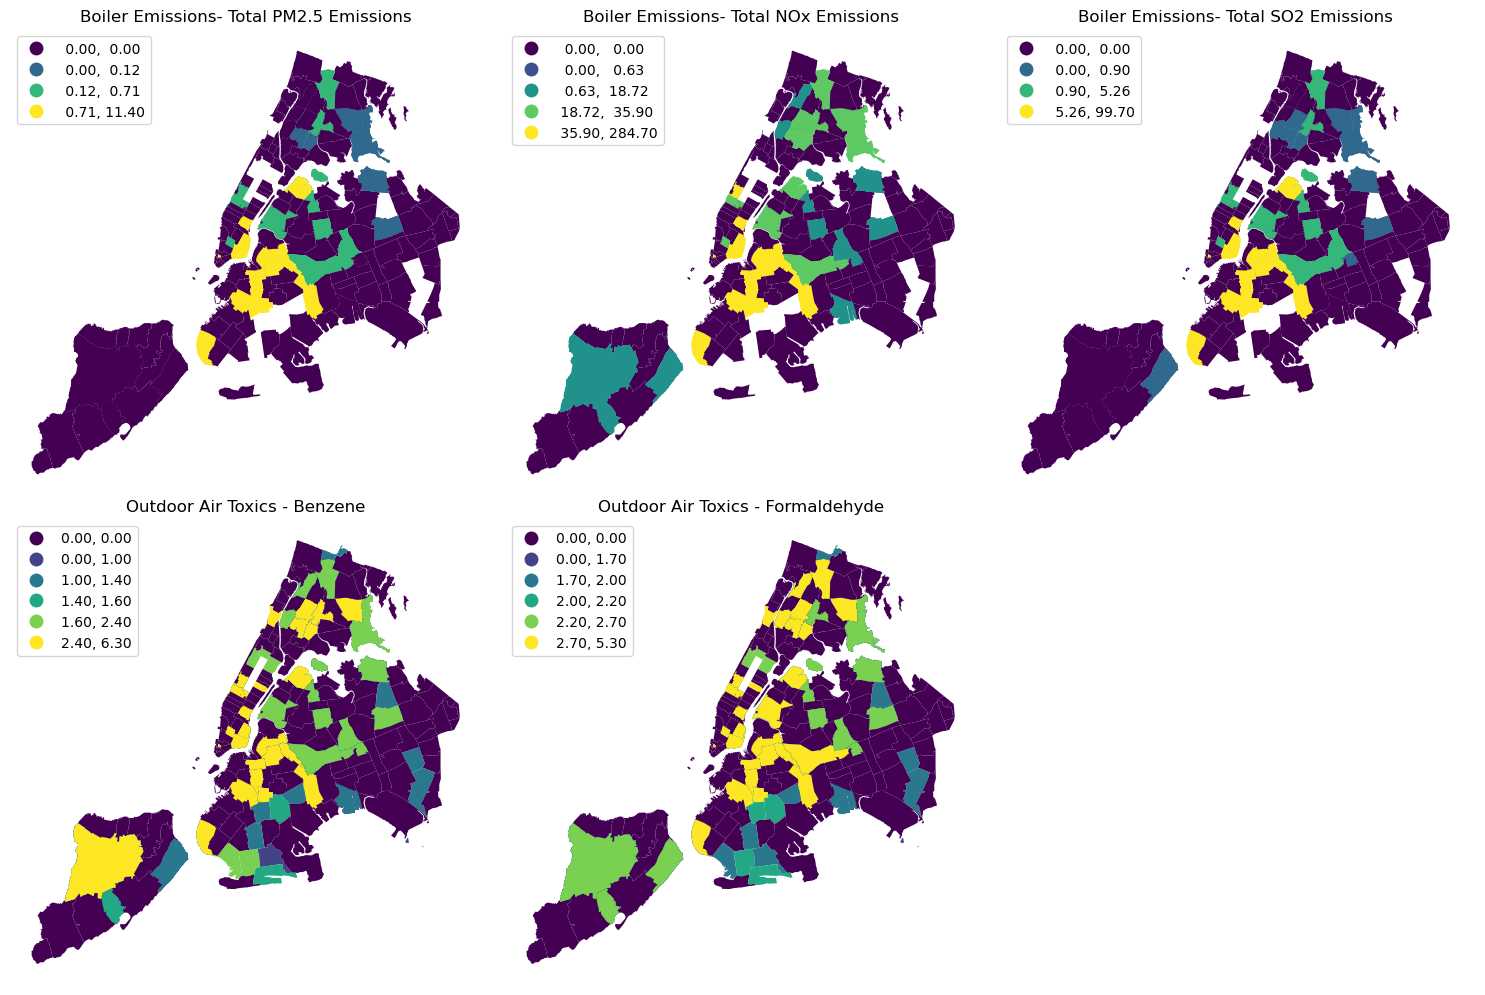

In [679]:
measure_types = air_quality_geo_merged_df['name'].unique()
cleaned_measure_types = [type_ for type_ in measure_types if type_ != '']

n_cols = 3
n_rows = math.ceil(len(cleaned_measure_types) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
axes = axes.flatten()  # Flatten axes to easily index them in a 1D array

for idx, (type_, ax) in enumerate(zip(cleaned_measure_types, axes)):
    air_quality_geo_trunc = gpd.GeoDataFrame(air_quality_geo_merged_df[(air_quality_geo_merged_df['name'] == type_) | (air_quality_geo_merged_df['name'] == '')])
    air_quality_geo_trunc.plot(
        ax=ax,
        column='data_value',
        markersize=0.01,
        k=10,
        scheme='Quantiles',
        legend=True,
        legend_kwds={'loc': 'upper left'}
    )
    ax.set_title(type_)
    ax.axis('off')

for ax in axes[len(cleaned_measure_types):]:
    ax.axis('off')
    
plt.tight_layout()
plt.show()

# Green Streets Data Sanitation

In [681]:
green_streets_df.head()

,Unnamed: 0,acres,borough,commissiondate,communityboard,councildistrict,department,description,featurestatus,gispropnum,...,precinct,sitename,starea,stlength,system,us_congress,zipcode,multipolygon,gstype,subcategory
0,0,0.070279,Q,2003-12-01T00:00:00.000,414.0,32.0,Q-14,Greenstreet,Active,QZ756,...,100,Greenstreet,3061.338028,411.528121,QZ756,5,11694,"{'type': 'MultiPolygon', 'coordinates': [[[[-7...",NaN,NaN
1,1,0.070278,Q,2003-12-01T00:00:00.000,414.0,32.0,Q-14,Greenstreet,Active,QZ755,...,100,Greenstreet,3061.295563,411.528010,QZ755,5,11694,"{'type': 'MultiPolygon', 'coordinates': [[[[-7...",NaN,NaN
2,2,0.070279,Q,2003-12-01T00:00:00.000,414.0,32.0,Q-14,Greenstreet,Active,QZ754,...,100,Greenstreet,3061.340775,411.528089,QZ754,5,11694,"{'type': 'MultiPolygon', 'coordinates': [[[[-7...",NaN,NaN
3,3,0.070278,Q,2003-12-01T00:00:00.000,414.0,32.0,Q-14,Greenstreet,Active,QZ753,...,100,Greenstreet,3061.310440,411.528121,QZ753,5,11694,"{'type': 'MultiPolygon', 'coordinates': [[[[-7...",NaN,NaN
4,4,0.070279,Q,2003-12-01T00:00:00.000,414.0,32.0,Q-14,Greenstreet,Active,QZ752,...,100,Greenstreet,3061.337860,411.528024,QZ752,5,11694,"{'type': 'MultiPolygon', 'coordinates': [[[[-7...",NaN,NaN


In [683]:
df = green_streets_df
df.columns = [i.upper() for i in df.columns]
print(df['DESCRIPTION'].isna().sum())
print((df['DESCRIPTION'] == "").sum())

df['ACRES']=df['ACRES'].astype(np.float64)

0
0


In [685]:
#Check for all invalid values in both acres and zipcode columns
df_invalid = df[
    df['ACRES'].isna() | (df['ACRES'] <= 0) | ~df['ACRES'].apply(lambda x: isinstance(x, (int, float)) and not pd.isna(x)) | (df['ACRES'] == '') |
    df['ZIPCODE'].isna() | (df['ZIPCODE'] == 0) | ~df['ZIPCODE'].apply(lambda x: str(x).isdigit()) | (df['ZIPCODE'] == '')
]

print("Rows with invalid Acres or ZIPCODE values:")
print(df_invalid[['ACRES', 'ZIPCODE']])

print(f"\nNumber of rows with invalid Acres or ZIPCODE: {df_invalid.shape[0]}")


Rows with invalid Acres or ZIPCODE values:
         ACRES              ZIPCODE
632   0.034391         11377, 11378
809   0.008332         11432, 11433
961   0.119891         11374, 11375
1072  0.069322         11213, 11233
1148  0.086223         11207, 11208
1379  0.034699         10463, 10471
1800  0.119379         11423, 11427
1823  0.019118         11370, 11371
1841  0.020756         11370, 11371
1842  0.020843         11370, 11371
1855  0.020318         11370, 11371
1856  0.022438         11370, 11371
1899  0.029911                  NaN
1900  0.044952                  NaN
1901  0.036727                  NaN
1902  0.039310                  NaN
1927  0.043888                 Null
1930  0.237340                 Null
1958  0.019172         11370, 11371
1968  1.203357         10025, 10027
1986  0.018848         11370, 11371
1987  0.019955         11370, 11371
2004  0.841732         10026, 10027
2091  0.409322  10003, 10010, 10016
2093  0.744071         11372, 11377
2098  0.125355       

In [687]:
#Drop all invalid values in both columns
df_cleaned = df[
    ~(df['ACRES'].isna() | (df['ACRES'] <= 0) | ~df['ACRES'].apply(lambda x: isinstance(x, (int, float)) and not pd.isna(x)) | (df['ACRES'] == '') |
    df['ZIPCODE'].isna() | (df['ZIPCODE'] == 0) | ~df['ZIPCODE'].apply(lambda x: str(x).isdigit()) | (df['ZIPCODE'] == '')
    )]
df_cleaned.shape

(2722, 27)

In [689]:
#Check for invalid values 
df_check = df_cleaned[
    df_cleaned['ACRES'].isna() | (df_cleaned['ACRES'] <= 0) | ~df_cleaned['ACRES'].apply(lambda x: isinstance(x, (int, float)) and not pd.isna(x)) | (df_cleaned['ACRES'] == '') |
    df_cleaned['ZIPCODE'].isna() | (df_cleaned['ZIPCODE'] == 0) | ~df_cleaned['ZIPCODE'].apply(lambda x: str(x).isdigit()) | (df_cleaned['ZIPCODE'] == '')
]
print(df_check[['ACRES', 'ZIPCODE']])

Empty DataFrame
Columns: [ACRES, ZIPCODE]
Index: []


In [691]:
#NYC zipcodes range from 10001 to 11697 in five boroughs.
nyc_zipcodes = [str(i) for i in range(10001, 11697)]
Greenstreets_filtered = df_cleaned[df_cleaned['ZIPCODE'].isin(nyc_zipcodes)]

Greenstreets_filtered.shape

(2716, 27)

In [917]:
Greenstreets_filtered.to_csv('data/filtered_greenstreets.csv', index=False)

In [695]:
Greenstreets_filtered = Greenstreets_filtered.rename(columns={'ZIPCODE': 'zipcode'})
Greenstreets_filtered['COMMUNITYBOARD'] = Greenstreets_filtered['COMMUNITYBOARD'].astype(np.int64)
Greenstreets_filtered.head(1)

,UNNAMED: 0,ACRES,BOROUGH,COMMISSIONDATE,COMMUNITYBOARD,COUNCILDISTRICT,DEPARTMENT,DESCRIPTION,FEATURESTATUS,GISPROPNUM,...,PRECINCT,SITENAME,STAREA,STLENGTH,SYSTEM,US_CONGRESS,zipcode,MULTIPOLYGON,GSTYPE,SUBCATEGORY
0,0,0.070279,Q,2003-12-01T00:00:00.000,414,32.0,Q-14,Greenstreet,Active,QZ756,...,100,Greenstreet,3061.338028,411.528121,QZ756,5,11694,"{'type': 'MultiPolygon', 'coordinates': [[[[-7...",NaN,NaN


In [697]:
Greenstreets_cb = Greenstreets_filtered\
    .groupby('COMMUNITYBOARD')\
    .agg({'ACRES': 'sum','DESCRIPTION':'count'})\
    .rename(columns={
        'ACRES': 'Greenstreets Acres Total', 
        'DESCRIPTION': 'Greenstreets Counts'
    })
Greenstreets_cb.head()


,Greenstreets Acres Total,Greenstreets Counts
COMMUNITYBOARD,,
101,2.170157,18
102,2.874612,42
103,3.978304,64
104,0.162693,27
105,0.747679,45


In [699]:
green_streets_df.rename(columns={
    'Unnamed: 0': 'Number','acres': 'ACRES','borough': 'BOROUGH','commissiondate': 'COMMISSIONDATE',
    'communityboard': 'COMMUNITYBOARD','councildistrict': 'COUNCILDISTRICT','department': 'DEPARTMENT',
    'description': 'DESCRIPTION','featurestatus': 'FEATURESTATUS','gispropnum': 'GISPROPNUM','gsgroup': 'GSGROUP',
    'gispropnum': 'GISPROPNUM','location': 'LOCATION','mou': 'MOU','nys_assembly': 'NYS_ASSEMBLY',
    'nys_senate': 'NYS_SENATE','omppropid': 'OMPPROPID','parentid': 'PARENTID','precinct': 'PRECINCT','sitename': 'SITENAME',
    'starea': 'STArea','stlength': 'STLength','system': 'SYSTEM','us_congress': 'US_CONGRESS','zipcode': 'ZIPCODE',
    'multipolygon': 'multipolygon','gstype': 'GSTYPE','subcategory': 'SUBCATEGORY'
}, inplace=True)

print(green_streets_df.columns)

Index(['UNNAMED: 0', 'ACRES', 'BOROUGH', 'COMMISSIONDATE', 'COMMUNITYBOARD',
       'COUNCILDISTRICT', 'DEPARTMENT', 'DESCRIPTION', 'FEATURESTATUS',
       'GISPROPNUM', 'GSGROUP', 'LOCATION', 'MOU', 'NYS_ASSEMBLY',
       'NYS_SENATE', 'OMPPROPID', 'PARENTID', 'PRECINCT', 'SITENAME', 'STAREA',
       'STLENGTH', 'SYSTEM', 'US_CONGRESS', 'ZIPCODE', 'MULTIPOLYGON',
       'GSTYPE', 'SUBCATEGORY'],
      dtype='object')


In [701]:
#Check for Greenstreets
print(green_streets_df['DESCRIPTION'].isna().sum())
print((green_streets_df['DESCRIPTION'] == "").sum())

0
0


In [42]:
#Check for all invalid values in both acres and zipcode columns
df_invalid = green_streets_df[
    green_streets_df['ACRES'].isna() | (green_streets_df['ACRES'] <= 0) | ~green_streets_df['ACRES'].apply(lambda x: isinstance(x, (int, float)) and not pd.isna(x)) | (green_streets_df['ACRES'] == '') |
    green_streets_df['ZIPCODE'].isna() | (green_streets_df['ZIPCODE'] == 0) | ~green_streets_df['ZIPCODE'].apply(lambda x: str(x).isdigit()) | (green_streets_df['ZIPCODE'] == '')
]

print("Rows with invalid Acres or ZIPCODE values:")
print(df_invalid[['ACRES', 'ZIPCODE']])

print(f"\nNumber of rows with invalid Acres or ZIPCODE: {df_invalid.shape[0]}")

Rows with invalid Acres or ZIPCODE values:
         ACRES              ZIPCODE
632   0.034391         11377, 11378
809   0.008332         11432, 11433
961   0.119891         11374, 11375
1072  0.069322         11213, 11233
1148  0.086223         11207, 11208
1379  0.034699         10463, 10471
1800  0.119379         11423, 11427
1823  0.019118         11370, 11371
1841  0.020756         11370, 11371
1842  0.020843         11370, 11371
1855  0.020318         11370, 11371
1856  0.022438         11370, 11371
1899  0.029911                  NaN
1900  0.044952                  NaN
1901  0.036727                  NaN
1902  0.039310                  NaN
1927  0.043888                 Null
1930  0.237340                 Null
1958  0.019172         11370, 11371
1968  1.203357         10025, 10027
1986  0.018848         11370, 11371
1987  0.019955         11370, 11371
2004  0.841732         10026, 10027
2091  0.409322  10003, 10010, 10016
2093  0.744071         11372, 11377
2098  0.125355       

In [703]:
#Drop all invalid values in both columns
df_cleaned = green_streets_df[
    ~(green_streets_df['ACRES'].isna() | (green_streets_df['ACRES'] <= 0) | ~green_streets_df['ACRES'].apply(lambda x: isinstance(x, (int, float)) and not pd.isna(x)) | (green_streets_df['ACRES'] == '') |
    green_streets_df['ZIPCODE'].isna() | (green_streets_df['ZIPCODE'] == 0) | ~green_streets_df['ZIPCODE'].apply(lambda x: str(x).isdigit()) | (green_streets_df['ZIPCODE'] == '')
    )]
df_cleaned.shape

(2722, 27)

In [705]:
#Check for invalid values 
df_check = df_cleaned[
    df_cleaned['ACRES'].isna() | (df_cleaned['ACRES'] <= 0) | ~df_cleaned['ACRES'].apply(lambda x: isinstance(x, (int, float)) and not pd.isna(x)) | (df_cleaned['ACRES'] == '') |
    df_cleaned['ZIPCODE'].isna() | (df_cleaned['ZIPCODE'] == 0) | ~df_cleaned['ZIPCODE'].apply(lambda x: str(x).isdigit()) | (df_cleaned['ZIPCODE'] == '')
]
print(df_check[['ACRES', 'ZIPCODE']])

Empty DataFrame
Columns: [ACRES, ZIPCODE]
Index: []


In [707]:
#NYC zipcodes range from 10001 to 11697 in five boroughs.
nyc_zipcodes = [str(i) for i in range(10001, 11697)]
Greenstreets_filtered = df_cleaned[df_cleaned['ZIPCODE'].isin(nyc_zipcodes)]

Greenstreets_filtered.shape

(2716, 27)

In [709]:
Greenstreets_filtered.to_csv('Filtered_Greenstreets.csv', index=False)

In [711]:
Greenstreets_filtered = Greenstreets_filtered.rename(columns={'ZIPCODE': 'zipcode'})
Greenstreets_filtered.head(1)

,UNNAMED: 0,ACRES,BOROUGH,COMMISSIONDATE,COMMUNITYBOARD,COUNCILDISTRICT,DEPARTMENT,DESCRIPTION,FEATURESTATUS,GISPROPNUM,...,PRECINCT,SITENAME,STAREA,STLENGTH,SYSTEM,US_CONGRESS,zipcode,MULTIPOLYGON,GSTYPE,SUBCATEGORY
0,0,0.070279,Q,2003-12-01T00:00:00.000,414.0,32.0,Q-14,Greenstreet,Active,QZ756,...,100,Greenstreet,3061.338028,411.528121,QZ756,5,11694,"{'type': 'MultiPolygon', 'coordinates': [[[[-7...",NaN,NaN


In [713]:
air_quality_geo_df['zipcode'] = air_quality_geo_df['zipcode'].astype(str)
Greenstreets_filtered['zipcode'] = Greenstreets_filtered['zipcode'].astype(str)

air_quality_geo_df = air_quality_geo_df.merge(Greenstreets_filtered, on='zipcode', how='inner')

In [715]:
#Here is the greenstreet data merged with air quailty and tree census
#Here is the greenstreet data merged with air quailty and tree census
#Here is the greenstreet data merged with air quailty and tree census
#Here is the greenstreet data merged with air quailty and tree census
#Here is the greenstreet data merged with air quailty and tree census
#Here is the greenstreet data merged with air quailty and tree census
air_quality_geo_df.columns

Index(['Unnamed: 0', 'unique_id', 'indicator_id', 'name', 'measure',
       'measure_info', 'geo_type_name', 'geo_join_id', 'geo_place_name',
       'time_period', 'start_date', 'data_value', 'zipcode', 'cb_num',
       'UNNAMED: 0', 'ACRES', 'BOROUGH', 'COMMISSIONDATE', 'COMMUNITYBOARD',
       'COUNCILDISTRICT', 'DEPARTMENT', 'DESCRIPTION', 'FEATURESTATUS',
       'GISPROPNUM', 'GSGROUP', 'LOCATION', 'MOU', 'NYS_ASSEMBLY',
       'NYS_SENATE', 'OMPPROPID', 'PARENTID', 'PRECINCT', 'SITENAME', 'STAREA',
       'STLENGTH', 'SYSTEM', 'US_CONGRESS', 'MULTIPOLYGON', 'GSTYPE',
       'SUBCATEGORY'],
      dtype='object')

In [717]:
NYCzip = gpd.read_file("https://raw.githubusercontent.com/CUSP2020PUI/Data/master/NY.geojson")

In [719]:
NYCzip['zipcode'] = NYCzip['zipcode'].astype(int)
NYCzip.head()

,zipcode,geometry
0,11372,"POLYGON Z ((-73.86942 40.74916 0.00000, -73.89..."
1,11004,"POLYGON Z ((-73.71068 40.75004 0.00000, -73.70..."
2,11040,"POLYGON Z ((-73.70098 40.73890 0.00000, -73.70..."
3,11426,"POLYGON Z ((-73.72270 40.75373 0.00000, -73.72..."
4,11365,"POLYGON Z ((-73.81089 40.72717 0.00000, -73.81..."


In [721]:
new = air_quality_geo_df.groupby('zipcode').agg({'ACRES': 'sum','DESCRIPTION':'count'}).reset_index()
new.head()

,zipcode,ACRES,DESCRIPTION
0,10002,40.077187,630
1,10009,5.593402,140
2,10012,22.514029,196
3,10016,1.813057,70
4,10019,3.078240,252


In [723]:
#Merge cleaned data with zipcode, Acres, and count of greenstreet with shapefile
NYCzip['zipcode'] = NYCzip['zipcode'].astype(str) 
new['zipcode'] = new['zipcode'].astype(str)  

merge_data = NYCzip.merge(new, left_on='zipcode', right_on='zipcode', how='left')

merge_data.head()

,zipcode,geometry,ACRES,DESCRIPTION
0,11372,"POLYGON Z ((-73.86942 40.74916 0.00000, -73.89...",NaN,NaN
1,11004,"POLYGON Z ((-73.71068 40.75004 0.00000, -73.70...",NaN,NaN
2,11040,"POLYGON Z ((-73.70098 40.73890 0.00000, -73.70...",NaN,NaN
3,11426,"POLYGON Z ((-73.72270 40.75373 0.00000, -73.72...",NaN,NaN
4,11365,"POLYGON Z ((-73.81089 40.72717 0.00000, -73.81...",34.952165,910.0


In [725]:
merge_data.dropna(subset=['ACRES', 'DESCRIPTION']).shape

(54, 4)

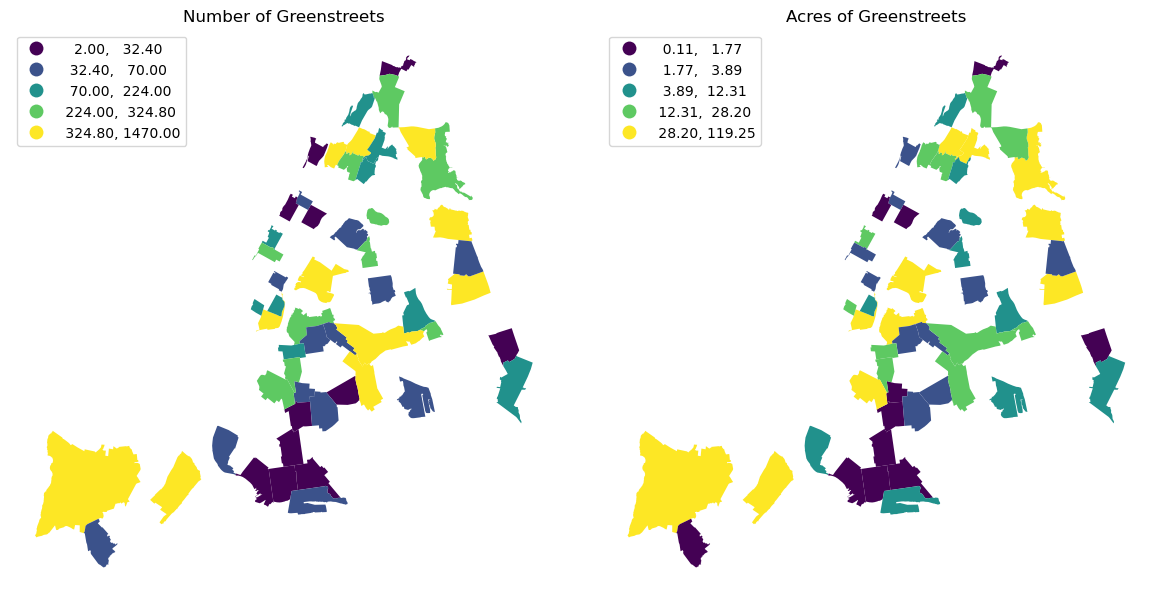

In [727]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

merge_data.plot(ax=axes[0], column='DESCRIPTION', legend=True, scheme='Quantiles', legend_kwds={'loc': 'upper left'})
axes[0].set_title('Number of Greenstreets')
axes[0].axis('off')  

merge_data.plot(ax=axes[1], column='ACRES', legend=True, scheme='Quantiles', legend_kwds={'loc': 'upper left'})
axes[1].set_title('Acres of Greenstreets')
axes[1].axis('off')  

plt.tight_layout()

plt.show()

# Property Valuation Data Sanitation

In [769]:
property_valuation_df.columns

Index(['Unnamed: 0', 'bble', 'boro', 'block', 'lot', 'owner', 'bldgcl',
       'taxclass', 'ltfront', 'ltdepth', 'stories', 'fullval', 'avland',
       'avtot', 'exland', 'extot', 'excd1', 'staddr', 'bldfront', 'blddepth',
       'avland2', 'avtot2', 'exland2', 'extot2', 'period', 'year', 'valtype',
       'zip', 'exmptcl', 'easement', 'borough', 'latitude', 'longitude',
       'community_board', 'council_district', 'census_tract', 'bin', 'nta',
       'geocoded_column', ':@computed_region_efsh_h5xi',
       ':@computed_region_f5dn_yrer', ':@computed_region_yeji_bk3q',
       ':@computed_region_92fq_4b7q', ':@computed_region_sbqj_enih', 'ext',
       'excd2'],
      dtype='object')

In [775]:
property_valuation_df = property_valuation_df.dropna(subset=['zip', 'borough'])
property_valuation_df['borough'].unique()

array(['MANHATTAN', 'BRONX', 'BROOKLYN', 'QUEENS', 'STATEN IS'],
      dtype=object)

In [777]:
property_valuation_df['community_board'].unique()

array([106., 104., 103., 102., 105., 107., 111., 201., 202., 212., 307.,
       301., 304., 312., 314., 311., 310., 315., 318.,  nan, 407., 409.,
       412., 413., 414., 101., 108., 110., 205., 317., 404., 411., 501.,
       502., 203., 109., 303., 306., 313., 401., 406., 405., 408., 308.,
       316., 402., 302., 403., 207., 208., 305., 204., 206., 210., 410.,
       503., 211., 209., 164., 112., 227., 228., 309., 226., 355., 356.,
       480., 481., 482., 483., 484., 595.])

In [779]:
property_valuation_df.shape

(1040480, 46)

In [781]:
property_valuation_df['zip'] = property_valuation_df['zip'].astype(int)
property_valuation_df['zip'].unique()

array([10010, 10019, 10002, 10009, 10003, 10014, 10016, 10036, 10024,
       10023, 10029, 10455, 10454, 10459, 10475, 11232, 11249, 11211,
       11206, 11222, 11237, 11219, 11218, 11204, 11209, 11228, 11214,
       11229, 11210, 11236, 11385, 11355, 11358, 11418, 11419, 11432,
       11433, 11423, 11429, 11434, 11694, 11691, 11692, 10013, 10001,
       10028, 10035, 10025, 10453, 10469, 10467, 10466, 11221, 11226,
       11203, 11230, 11235, 11373, 11368, 10301, 10314, 10303, 10011,
       10022, 10128, 10027, 10456, 10039, 10451, 11205, 11215, 11207,
       11223, 11103, 11374, 11375, 11378, 11366, 11436, 10305, 10038,
       10031, 11217, 11238, 11212, 11220, 11102, 11106, 11377, 11354,
       11427, 11426, 11413, 10026, 11216, 11224, 11105, 11372, 11357,
       11367, 11435, 10457, 10463, 11421, 11231, 11361, 10302, 10452,
       10460, 10465, 11364, 11417, 11416, 11420, 10312, 10012, 10017,
       10018, 10065, 11201, 10280, 10004, 10007, 10005, 10282, 10006,
       10041, 10045,

In [783]:
col_keep = ['zip', 'boro', 'borough', 'latitude', 'longitude', 'fullval', 'taxclass', 'bldgcl', 'stories', 'community_board', 'nta', 'year']
filtered_property_valuation_df = property_valuation_df[col_keep]
filtered_property_valuation_df.head()

,zip,boro,borough,latitude,longitude,fullval,taxclass,bldgcl,stories,community_board,nta,year
16,10010,1,MANHATTAN,40.737730,-73.980554,0,2,R0,19.0,106.0,Gramercy,2018/19
17,10019,1,MANHATTAN,40.763878,-73.989853,0,2,R0,16.0,104.0,Clinton,2018/19
35,10002,1,MANHATTAN,40.719649,-73.991800,0,2,R0,16.0,103.0,Chinatown,2018/19
36,10002,1,MANHATTAN,40.718795,-73.994657,0,2,R0,8.0,103.0,Chinatown,2018/19
37,10009,1,MANHATTAN,40.725912,-73.983649,0,2,R0,6.0,103.0,East Village,2018/19


In [785]:
filtered_property_valuation_df['Start_Year'] = filtered_property_valuation_df['year'].str.split('/').str[0].astype(int)
filtered_property_valuation_df = filtered_property_valuation_df[filtered_property_valuation_df['Start_Year'] >= 2014]
filtered_property_valuation_df = filtered_property_valuation_df.drop(columns=['Start_Year','year'])
filtered_property_valuation_df.shape

(1040230, 11)

In [787]:
filtered_property_valuation_df = filtered_property_valuation_df[filtered_property_valuation_df['fullval'] > 0]
filtered_property_valuation_df['fullval'].describe()

count    1.030308e+06
mean     1.360321e+06
std      1.581366e+07
min      1.200000e+01
25%      3.880000e+05
50%      6.080000e+05
75%      9.650000e+05
max      7.786157e+09
Name: fullval, dtype: float64

In [789]:
median_value = filtered_property_valuation_df['fullval'].median()
zero_count = (filtered_property_valuation_df['fullval'] == 0).sum()
print('median:', median_value)
print('zero count:', zero_count)

median: 608000.0
zero count: 0


In [791]:
print(filtered_property_valuation_df['taxclass'].unique())
print(filtered_property_valuation_df['bldgcl'].unique())

['2C' '1' '1B' '1C' '1A' '4' '2' '2B' '2A' '1D' '3']
['R8' 'C0' 'V0' 'R6' 'R1' 'R3' 'A5' 'RP' 'B1' 'B3' 'B2' 'R4' 'H4' 'C1'
 'A2' 'R2' 'A1' 'I5' 'S1' 'G0' 'E9' 'C3' 'A6' 'S2' 'RG' 'O8' 'P3' 'R5'
 'Z0' 'A9' 'A3' 'D1' 'RK' 'RB' 'G6' 'RS' 'K4' 'O5' 'RH' 'O7' 'C7' 'RW'
 'O4' 'D5' 'S5' 'O2' 'D7' 'P9' 'S3' 'RR' 'O6' 'S4' 'L9' 'D3' 'Y3' 'A4'
 'Y4' 'H3' 'O3' 'D8' 'V1' 'RT' 'S9' 'L8' 'D4' 'RA' 'C4' 'Q9' 'D0' 'D6'
 'K1' 'HS' 'C6' 'G1' 'Y7' 'M1' 'Q1' 'H2' 'R9' 'HR' 'D9' 'L2' 'W6' 'F5'
 'D2' 'K2' 'Z9' 'W1' 'W5' 'K9' 'W8' 'H8' 'Y1' 'HB' 'M3' 'Q2' 'Z3' 'H1'
 'P7' 'K6' 'O1' 'A7' 'G7' 'R7' 'M9' 'W2' 'Z1' 'Z4' 'Y2' 'O9' 'J1' 'K7'
 'C2' 'Y6' 'P5' 'T9' 'M2' 'H5' 'T2' 'F1' 'I1' 'K5' 'C8' 'B9' 'C5' 'K3'
 'P1' 'G9' 'N9' 'V9' 'J9' 'I6' 'W9' 'J5' 'N2' 'E7' 'L3' 'C9' 'J8' 'M4'
 'H9' 'P2' 'G2' 'HH' 'I9' 'E1' 'V5' 'Z8' 'Y9' 'P8' 'W3' 'Y8' 'S0' 'J3'
 'P6' 'I7' 'J7' 'F9' 'G4' 'I2' 'J4' 'Q6' 'W4' 'I4' 'E2' 'Z2' 'H6' 'L1'
 'G3' 'N4' 'W7' 'G8' 'A0' 'J6' 'V4' 'J2' 'GW' 'V7' 'T1' 'I3' 'Z5' 'H7'
 'Z7' 'Q3' 'F2' 'U0' 'Q7

In [793]:
print(filtered_property_valuation_df['community_board'].unique())
len(filtered_property_valuation_df['community_board'].unique())

[201. 202. 212. 301. 311. 312. 318.  nan 407. 409. 412. 106. 104. 304.
 317. 310. 314. 404. 102. 401. 405. 411. 501. 103. 316. 413. 306. 313.
 101. 105. 107. 211. 209. 210. 164. 307. 108. 111. 109. 204. 205. 203.
 110. 206. 207. 112. 208. 227. 308. 228. 302. 226. 305. 309. 355. 303.
 315. 402. 356. 403. 410. 414. 480. 406. 481. 482. 408. 483. 484. 502.
 503. 595.]


72

In [795]:
filtered_property_valuation_df = filtered_property_valuation_df.sample(frac=0.1, random_state=42)

`zip`: ZIP code

`boro`: Borough number

`borough`: Borough name

`latitude`, `longitude`: Lat & Lon (for map)

`fullval`: Total value of the property. Many 0 in the data, need to find a method to solve it. 

`bldgcl`: Building class (*too many kinds, maybe useless* )

`taxclass` (*compare to Building class, more useful*): 
* 1: One- to three-family residential properties.
* 2: Multi-family residential properties (e.g., apartment buildings).
* 3: Utility properties (e.g., power lines, substations).
* 4: Commercial and industrial properties.

stories: Number of floors

`community_board`: community districts in NYC. Formed by three numbers, the 1st number means Borough number, the last 2 numbers are community districts in that Borough. e.g. 101 -> Community District 1 in Manhattan (*Maybe useful?*)

`nta`: Area Names

In [875]:
filtered_property_valuation_df.to_csv('data/filtered_properties.csv')

In [851]:
air_qual = load_data('data/Air_Quality_20241206.csv', 'https://data.cityofnewyork.us/resource/c3uy-2p5r.json')

In [853]:
air_qual['geo_join_id'] = air_qual['geo_join_id'].fillna(0)
air_qual['geo_join_id'] = air_qual['geo_join_id'].astype(int)
print(air_qual['geo_join_id'].unique())

[      104       405       302       103       502       301       101
       204       201       412       414       402       107       106
       401       408    503504       304       313       406       410
       315       308       102       207         5       205       208
       202       212       311         3       310       316       404
       403       303       211       501       411       504       209
    501502       409         4       317       111    404406       203
         1       309       407         2       413 105106107       306
       206       318       503       210       108       110       112
       109       312       307       305       314    305307    306308
       105    309310         0]


In [861]:
filtered_values = air_qual['geo_join_id'].apply(lambda x: len(str(x)) == 3)
filtered_air_qual = air_qual[filtered_values]
print(len(filtered_air_qual['geo_join_id'].unique()))
filtered_air_qual['geo_join_id'].unique()

60


array([104, 405, 302, 103, 502, 301, 101, 204, 201, 412, 414, 402, 107,
       106, 401, 408, 304, 313, 406, 410, 315, 308, 102, 207, 205, 208,
       202, 212, 311, 310, 316, 404, 403, 303, 211, 501, 411, 504, 209,
       409, 317, 111, 203, 309, 407, 413, 306, 206, 318, 503, 210, 108,
       110, 112, 109, 312, 307, 305, 314, 105])

In [863]:
sample_properties = filtered_property_valuation_df.rename(columns={'community_board': 'geo_join_id'})
sample_properties.head()

,zip,boro,borough,latitude,longitude,fullval,taxclass,bldgcl,stories,geo_join_id,nta
385379,11216,3,BROOKLYN,40.680338,-73.948760,663000,4,K1,1.0,303.0,Crown Heights North
638335,11101,4,QUEENS,40.753399,-73.939157,192000,4,E1,1.0,401.0,Queensbridge-Ravenswood-Long Island City
979014,11413,4,QUEENS,40.670147,-73.751035,509000,1,B2,2.0,413.0,Laurelton
920509,11428,4,QUEENS,40.721607,-73.746694,525000,1,A1,2.5,413.0,Queens Village
1024654,10304,5,STATEN IS,40.628791,-74.076523,933000,2A,S4,3.0,501.0,Stapleton-Rosebank


In [865]:
print(len(sample_properties['geo_join_id'].unique()))
sample_properties['geo_join_id'].unique()

60


array([303., 401., 413., 501., 410., 318., 408., 405., 309., 210., 406.,
       308., 209., 103., 404., 106., 310., 407., 108., 107., 212., 312.,
       105., 207., 315., 104., 412., 102., 313., 307., 306., 301., 311.,
       302., 316., 110., 402., 317., 411., 201., 304., 502., 203., 414.,
       409., 503., 101., 314., 112., 305., 202., 208., 206., 211., 403.,
       111., 204., 109., 205.,  nan])

In [867]:
valid_community_boards = sample_properties['geo_join_id'].unique()
filtered_air_qual = filtered_air_qual[filtered_air_qual['geo_join_id'].isin(valid_community_boards)]
print(len(filtered_air_qual['geo_join_id'].unique()))
filtered_air_qual['geo_join_id'].unique()

59


array([104, 405, 302, 103, 502, 301, 101, 204, 201, 412, 414, 402, 107,
       106, 401, 408, 304, 313, 406, 410, 315, 308, 102, 207, 205, 208,
       202, 212, 311, 310, 316, 404, 403, 303, 211, 501, 411, 209, 409,
       317, 111, 203, 309, 407, 413, 306, 206, 318, 503, 210, 108, 110,
       112, 109, 312, 307, 305, 314, 105])

In [869]:
filtered_air_qual['year'] = pd.to_datetime(filtered_air_qual['start_date'], errors='coerce').dt.year
filtered_air_qual = filtered_air_qual[filtered_air_qual['year'] >= 2014]
filtered_air_qual = filtered_air_qual.drop(columns = ['indicator_id', 'time_period'])
filtered_air_qual.shape

(8818, 11)

In [877]:
filtered_air_qual.to_csv('data/filtered_air_qual.csv')

In [879]:
filtered_air_qual.head()

,Unnamed: 0,unique_id,name,measure,measure_info,geo_type_name,geo_join_id,geo_place_name,start_date,data_value,year
0,0,827080,Ozone (O3),Mean,ppb,UHF34,104,Pelham - Throgs Neck,2022-06-01T00:00:00.000,33.3,2022
1,1,827061,Ozone (O3),Mean,ppb,UHF34,405,Ridgewood - Forest Hills,2022-06-01T00:00:00.000,34.2,2022
2,2,827067,Ozone (O3),Mean,ppb,UHF34,302,Central Harlem - Morningside Heights,2022-06-01T00:00:00.000,30.9,2022
3,3,827081,Ozone (O3),Mean,ppb,UHF34,103,Fordham - Bronx Pk,2022-06-01T00:00:00.000,31.7,2022
4,4,825967,Nitrogen dioxide (NO2),Mean,ppb,UHF34,104,Pelham - Throgs Neck,2022-06-01T00:00:00.000,12.0,2022


In [881]:
filtered_air_qual['name'].unique()

array(['Ozone (O3)', 'Nitrogen dioxide (NO2)', 'Fine particles (PM 2.5)',
       'Annual vehicle miles traveled (cars)',
       'Annual vehicle miles traveled (trucks)',
       'Annual vehicle miles traveled',
       'Respiratory hospitalizations due to PM2.5 (age 20+)',
       'Asthma emergency department visits due to PM2.5',
       'Asthma emergency departments visits due to Ozone',
       'Cardiovascular hospitalizations due to PM2.5 (age 40+)',
       'Cardiac and respiratory deaths due to Ozone',
       'Asthma hospitalizations due to Ozone', 'Deaths due to PM2.5',
       'Boiler Emissions- Total PM2.5 Emissions',
       'Boiler Emissions- Total SO2 Emissions',
       'Boiler Emissions- Total NOx Emissions',
       'Outdoor Air Toxics - Formaldehyde',
       'Outdoor Air Toxics - Benzene'], dtype=object)

In [885]:
filtered_air_qual[filtered_air_qual['name'] == 'Fine particles (PM 2.5)']

,Unnamed: 0,unique_id,name,measure,measure_info,geo_type_name,geo_join_id,geo_place_name,start_date,data_value,year
10,10,823561,Fine particles (PM 2.5),Mean,mcg/m3,CD,412,Jamaica and Hollis (CD12),2022-06-01T00:00:00.000,6.3,2022
11,11,823214,Fine particles (PM 2.5),Mean,mcg/m3,CD,104,Clinton and Chelsea (CD4),2022-06-01T00:00:00.000,8.0,2022
15,15,823310,Fine particles (PM 2.5),Mean,mcg/m3,UHF42,106,High Bridge - Morrisania,2022-06-01T00:00:00.000,7.1,2022
16,16,823397,Fine particles (PM 2.5),Mean,mcg/m3,UHF34,401,Long Island City - Astoria,2022-06-01T00:00:00.000,7.2,2022
17,17,823382,Fine particles (PM 2.5),Mean,mcg/m3,UHF34,408,Jamaica,2022-06-01T00:00:00.000,6.3,2022
...,...,...,...,...,...,...,...,...,...,...,...
9734,9734,213936,Fine particles (PM 2.5),Mean,mcg/m3,CD,106,Stuyvesant Town and Turtle Bay (CD6),2014-06-01T00:00:00.000,11.7,2014
9735,9735,213978,Fine particles (PM 2.5),Mean,mcg/m3,CD,406,Rego Park and Forest Hills (CD6),2014-06-01T00:00:00.000,8.5,2014
9737,9737,212824,Fine particles (PM 2.5),Mean,mcg/m3,UHF42,403,Flushing - Clearview,2014-06-01T00:00:00.000,8.2,2014
9738,9738,213960,Fine particles (PM 2.5),Mean,mcg/m3,CD,306,Park Slope and Carroll Gardens (CD6),2014-06-01T00:00:00.000,9.9,2014


In [889]:
aggregated_properties = sample_properties.groupby('geo_join_id').agg({
    'fullval': 'mean',
    'bldgcl': lambda x: x.mode()[0],
    'stories': 'mean'
}).reset_index()

aggregated_properties.head()

,geo_join_id,fullval,bldgcl,stories
0,101.0,1.173308e+06,R4,23.537267
1,102.0,4.329452e+06,R4,9.487179
2,103.0,1.847458e+06,R4,6.968919
3,104.0,2.422722e+06,R4,21.567742
4,105.0,1.310892e+07,R4,26.872727


In [891]:
pm25_df = filtered_air_qual[filtered_air_qual['name'] == 'Fine particles (PM 2.5)']
pm25_df = pm25_df.groupby(['geo_join_id'])['data_value'].mean().reset_index()
pm25_df.head()

,geo_join_id,data_value
0,101,8.242667
1,102,8.425333
2,103,8.169333
3,104,8.401333
4,105,9.750000


In [897]:
merged_df = aggregated_properties.merge(pm25_df, on='geo_join_id', how='inner')
merged_df.head()

,geo_join_id,fullval,bldgcl,stories,data_value
0,101.0,1.173308e+06,R4,23.537267,8.242667
1,102.0,4.329452e+06,R4,9.487179,8.425333
2,103.0,1.847458e+06,R4,6.968919,8.169333
3,104.0,2.422722e+06,R4,21.567742,8.401333
4,105.0,1.310892e+07,R4,26.872727,9.750000


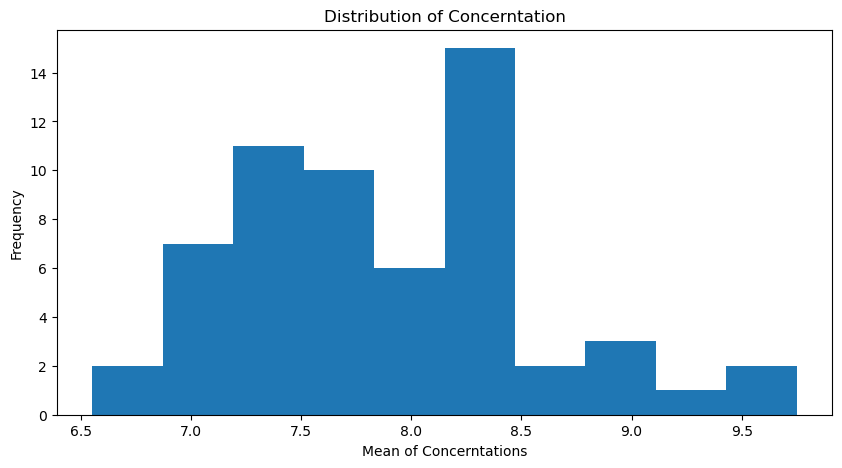

In [901]:
plt.figure(figsize=(10, 5))
plt.hist(merged_df['data_value'], bins = 10)
plt.title('Distribution of Concerntation')
plt.xlabel('Mean of Concerntations')
plt.ylabel('Frequency')
plt.show()

In [903]:
from scipy.stats import kruskal
grouped = merged_df.groupby(['fullval', 'bldgcl', 'stories'])

grouped_data = [group['data_value'].values for _, group in grouped]

stat, p_value = kruskal(*grouped_data)

print(f"Kruskal-Wallis Statistic: {stat:.3f}")
print(f"P-value: {p_value:.3e}")

Kruskal-Wallis Statistic: 58.000
P-value: 4.753e-01


In [905]:
import statsmodels.api as sm
X = merged_df[['fullval', 'stories']]
X = sm.add_constant(X)
y = merged_df['data_value']

model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             data_value   R-squared:                       0.333
Model:                            OLS   Adj. R-squared:                  0.309
Method:                 Least Squares   F-statistic:                     13.98
Date:                Mon, 09 Dec 2024   Prob (F-statistic):           1.19e-05
Time:                        14:49:03   Log-Likelihood:                -48.715
No. Observations:                  59   AIC:                             103.4
Df Residuals:                      56   BIC:                             109.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.5105      0.103     72.585      0.0

# Combined Analysis

In [907]:
air_quality_cb = air_quality_geo_df.loc[air_quality_geo_df['geo_type_name']=='CD'][[
    'geo_join_id','name','data_value'
]].drop_duplicates()

air_quality_cb = air_quality_cb.pivot(
    index='geo_join_id', columns='name', values='data_value'
)

#build master dataset
combined = pd.concat((air_quality_cb, tree_census_geoms, Greenstreets_cb),axis=1).dropna()
combined_no_geom = combined.drop(columns=['geometry'])
combined_no_geom.head()


,Outdoor Air Toxics - Benzene,Outdoor Air Toxics - Formaldehyde,Tree Quality,Tree Density (per Acre),Greenstreets Acres Total,Greenstreets Counts
102,2.6,2.6,0.730602,5.580675,2.874612,42
103,2.2,2.5,0.764069,4.375522,3.978304,64
104,2.9,2.9,0.824395,3.903700,0.162693,27
105,3.4,3.0,0.673560,2.020331,0.747679,45
106,2.5,2.7,0.760896,5.470581,0.686884,13


In [909]:
#correlation matrix
combined_no_geom.corr()


,Outdoor Air Toxics - Benzene,Outdoor Air Toxics - Formaldehyde,Tree Quality,Tree Density (per Acre),Greenstreets Acres Total,Greenstreets Counts
Outdoor Air Toxics - Benzene,1.000000,0.945971,-0.587765,0.126215,-0.360270,-0.239240
Outdoor Air Toxics - Formaldehyde,0.945971,1.000000,-0.551304,0.200001,-0.397934,-0.292707
Tree Quality,-0.587765,-0.551304,1.000000,-0.034631,0.137049,0.072047
Tree Density (per Acre),0.126215,0.200001,-0.034631,1.000000,-0.311956,-0.277668
Greenstreets Acres Total,-0.360270,-0.397934,0.137049,-0.311956,1.000000,0.945600
Greenstreets Counts,-0.239240,-0.292707,0.072047,-0.277668,0.945600,1.000000


Corr[Tree Quality,Outdoor Air Toxics - Benzene] = -0.587764537371241
Corr[Tree Quality,Outdoor Air Toxics - Formaldehyde] = -0.5513039789780879
Corr[Tree Density (per Acre),Outdoor Air Toxics - Benzene] = 0.12621540166959583
Corr[Tree Density (per Acre),Outdoor Air Toxics - Formaldehyde] = 0.2000010868098281
Corr[Greenstreets Acres Total,Outdoor Air Toxics - Benzene] = -0.36026956577185615
Corr[Greenstreets Acres Total,Outdoor Air Toxics - Formaldehyde] = -0.397933802261986
Corr[Greenstreets Counts,Outdoor Air Toxics - Benzene] = -0.23923958654735344
Corr[Greenstreets Counts,Outdoor Air Toxics - Formaldehyde] = -0.29270674391019647


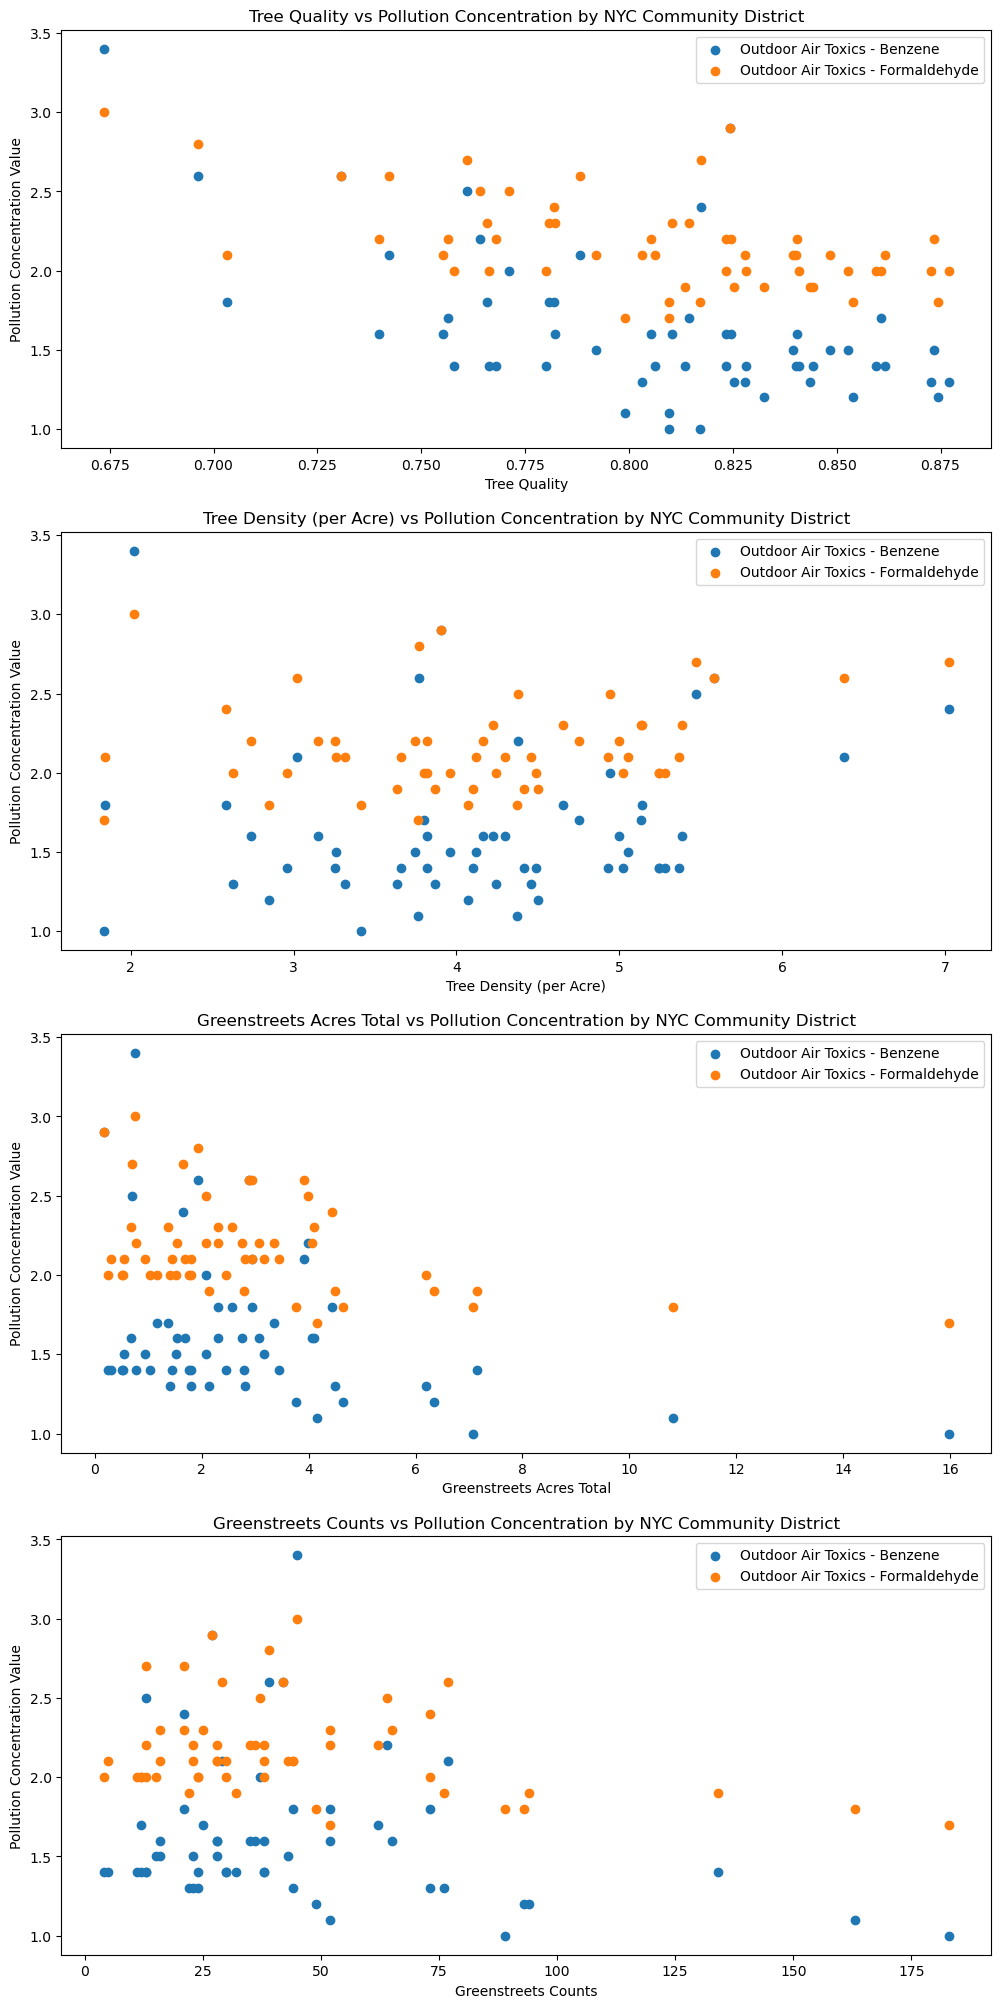

In [911]:
targets = combined_no_geom.columns[0:2]
predictors = combined_no_geom.columns[2:] 

#scatter plot of each feature wrto pollution type
fig,ax=plt.subplots(len(predictors),1,figsize=(12,25))
ax_feat_map = list(zip(ax, predictors))
for _ax, f in ax_feat_map:
    for p_type in targets:
        x = combined_no_geom[f]
        y = combined_no_geom[p_type]

        #calculate correlation coef for each feature we iterate and print..
        corr = np.corrcoef(x,y)[0,1]
        print(f'Corr[{f},{p_type}] = {corr}')

        _ax.scatter(
            x=x, y=y,label=p_type
        )
    _ax.legend()
    _ax.set_xlabel(f)
    _ax.set_ylabel('Pollution Concentration Value')
    _ax.set_title(f'{f} vs Pollution Concentration by NYC Community District')
plt.show()


In [913]:

#statsmodels doesn't accept spaces in col names...
combined_no_geom.columns = [
    re.sub(r'[^a-zA-Z0-9\s]', ' ', i).replace(" ",'_') for i in combined_no_geom.columns
]

targets = combined_no_geom.columns[0:2]
predictors = combined_no_geom.columns[2:] 

#ensure all values in df are floats...
combined = combined_no_geom.astype(np.float64)

#run regression analysis, measure hypothesis whether or not some variable is a "predictor" of emissions/pollution 
#that is, the reg weight = 0 under the null, weight != 0 otherwise 
alpha,pv_df = 0.05,[]
for t in targets:
    formula = f"{t} ~ {'+'.join(predictors)}"
    print(formula)
    lm = smf.ols(formula = formula, data = combined_no_geom).fit() 
    pv=pd.DataFrame(lm.pvalues,columns=[t])
    pv_df.append(pv)

    print(f'R2 [TARGET: {t}]: {lm.rsquared}')
   
pv_df = pd.concat(pv_df,axis=1)
pv_df

Outdoor_Air_Toxics___Benzene ~ Tree_Quality+Tree_Density__per_Acre_+Greenstreets_Acres_Total+Greenstreets_Counts
R2 [TARGET: Outdoor_Air_Toxics___Benzene]: 0.47287209914992956
Outdoor_Air_Toxics___Formaldehyde ~ Tree_Quality+Tree_Density__per_Acre_+Greenstreets_Acres_Total+Greenstreets_Counts
R2 [TARGET: Outdoor_Air_Toxics___Formaldehyde]: 0.44431058252436584


,Outdoor_Air_Toxics___Benzene,Outdoor_Air_Toxics___Formaldehyde
Intercept,1.747974e-08,8.725050e-11
Tree_Quality,1.094082e-05,4.698795e-05
Tree_Density__per_Acre_,9.493744e-01,4.795124e-01
Greenstreets_Acres_Total,5.842714e-03,2.013967e-02
Greenstreets_Counts,3.723462e-02,1.191577e-01


In [915]:
pv_df < alpha

,Outdoor_Air_Toxics___Benzene,Outdoor_Air_Toxics___Formaldehyde
Intercept,True,True
Tree_Quality,True,True
Tree_Density__per_Acre_,False,False
Greenstreets_Acres_Total,True,True
Greenstreets_Counts,True,False
